In [2]:
from matplotlib import pyplot as plt
from scipy import signal
import numpy as np
import random

In [3]:
%matplotlib inline

In [4]:
shape=(19, 19)

In [5]:
class Gomoku:
    
    def __init__(self, shape):
        self.shape = shape
        self.reset()
        
    def reset(self):
        self.last_player = 1
        self.last_action = None
        self.board = np.stack((np.zeros(self.shape), np.zeros(self.shape),np.ones(self.shape)), axis=2)
        self.previous_board = np.copy(self.board)
    
    def draw(self):
        plt.imshow(self.board)
    
    def list_actions(self):
        return np.transpose(np.nonzero(self.board[:,:,2])).tolist()
        
    def take_action(self, action):
        self.previous_board = np.copy(self.board)
        self.last_player = 1 - self.last_player 
        pixel = np.zeros((3))
        pixel[self.last_player] = 1
        self.board[action] = pixel
        self.last_action = action
        return self.__revard()
    
    def get_last_action(self):
        return self.last_action
    
    def get_state(self):
        return self.convert_state_for_player(self.board, self.last_player)
    
    def get_raw_state(self):
        return self.board
    
    def get_previous_state(self):
        return self.convert_state_for_player(self.previous_board, self.last_player)
    
    def convert_state_for_player(self, board, player):
        result = np.copy(board)
        
        if player == 1:
            result[:,:,[0,1]] = result[:,:,[1,0]]
        
        return result

    def game_over(self):
        return self.__won(0) or self.__won(1) or np.count_nonzero(self.board[:,:,2]) == 0
    
    def __revard(self):
        return 1 if self.__won(self.last_player) else 0
        
    def __won(self, player):
        board = self.board[:,:, player]
        return (
            self.__has_five_by(np.identity(5), board) or 
            self.__has_five_by(np.fliplr(np.identity(5)), board) or 
            self.__has_five_by(np.ones((1,5)), board) or 
            self.__has_five_by(np.ones((5,1)), board)
        )
    
    def __has_five_by(self, mask, board):
        return np.count_nonzero(signal.convolve2d(mask, board) == 5) > 0
    
game = Gomoku(shape)

In [6]:
delta = 0.3

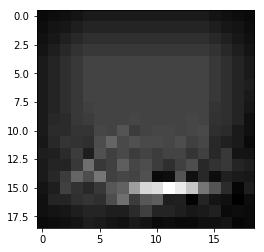

In [53]:
import math


power_map = np.vectorize(lambda x: 2 ** x)

def sigmoid(x):
  return 1 / (1 + math.exp(-x))

def get_value_for_mask(mask, board):
    free = signal.convolve2d(1 -board[:,:,0], mask, mode='same') == 5
    mine = power_map(signal.convolve2d(board[:,:,1], mask, mode='same'))
    
    enemy_free = signal.convolve2d(1 -board[:,:,1], mask, mode='same') == 5
    enemy = power_map(signal.convolve2d(board[:,:,0], mask, mode='same'))
    
    return (
        signal.convolve2d(np.multiply(free, mine), mask, mode='same') +
        signal.convolve2d(np.multiply(enemy_free, enemy), mask, mode='same')
    )
    

def get_value_map(board):
        return (
            get_value_for_mask(np.ones((1,5)), board) + 
            get_value_for_mask(np.ones((5,1)), board) +
            get_value_for_mask(np.identity(5), board) + 
            get_value_for_mask(np.fliplr(np.identity(5)), board)
        )
            

plt.imshow(get_value_map(game.get_state()), cmap='gray')


In [54]:
import random

def make_move():
    if game.game_over():
        return
    
    #q = get_value_map(game.get_state())
    q = np.squeeze(model.predict(np.array([game.get_state()])))
    list_of_actions = game.list_actions()
    random.shuffle(list_of_actions)
    prefered_moves = sorted(list_of_actions, key=lambda x: -q[tuple(x)])
        
    i = 0
    while np.random.rand() < delta and i < len(prefered_moves)-1:
        i += 1

    game.take_action(tuple(prefered_moves[i]))

def make_manual_move(i, j):
    if game.game_over():
        return
    
    game.take_action((i,j))

In [60]:
from IPython.core.display import display as core_display
from IPython.core.display import HTML 

def state_for_display():
    raw_state = game.get_raw_state()
    last_action = game.get_last_action()
    #color_map = get_value_map(game.get_state())
    color_map = np.squeeze(model.predict(np.array([game.get_state()])))
    color_map = color_map - np.min(color_map)
    if np.max(color_map) > 0:
        color_map = (color_map / np.max(color_map) * 255).astype(int)
    
    html = '<table>'
    for i in range(shape[0]):
        html += '<tr>'
        for j in range(shape[1]):
                        
            html += "<td style='border:1px solid gray; width:25px; height:25px; fotn-weight:bold; text-align:center; "
            if last_action == (i,j): 
                html += "background-color:rgb(255, "+str(color_map[i,j])+", "+str(255-color_map[i,j])+");" 
            else: 
                html += "background-color:rgb(0, "+ str(color_map[i,j]) +", "+str(255-color_map[i,j])+");" 
                
            html += "'"
            if raw_state[i,j,2]:
                html += " onclick='make_move("+str(i)+","+str(j)+")'"
            html += ">"
            if raw_state[i,j,0] == 1:
                html += 'X'
            if raw_state[i,j,1] == 1:
                html += 'O'
            if raw_state[i,j,0] == 1:
                html += '&nbsp;'                
                
            html += "</td>"
        html += '</tr>'

    html += '</table>'
    if game.game_over():
        html += '<h3>Game Over</h3>'
    print(html)

game.reset()



html = """

<div id='display_div'></div>
<button onclick='reset()'>New Game</button>
<button onclick='next()'>Make a move</button>

<script type="text/Javascript">

    function display_state(out) {
        document.getElementById('display_div').innerHTML = out.content.text;
    }
    
    function next() {
        var kernel = IPython.notebook.kernel;
        kernel.execute('make_move()', {"iopub" : {"output": console.log}});
        kernel.execute('state_for_display()', {"iopub" : {"output":display_state}});
    }

    function make_move(i,j) {
        var kernel = IPython.notebook.kernel;
        kernel.execute('make_manual_move('+i+', '+j+')');
        kernel.execute('state_for_display()', {"iopub" : {"output":display_state}});
    }
    
    function reset() {
        var kernel = IPython.notebook.kernel;
        kernel.execute('game.reset()');
        kernel.execute('state_for_display()', {"iopub" : {"output":display_state}});
    }

    reset();

</script>
"""

core_display(HTML(html))

In [10]:
from keras.models import Sequential
from keras.layers.core import Dropout
from keras.layers.convolutional import Conv2D
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Nadam

from IPython import display

Using TensorFlow backend.


In [13]:
hidden_layer_count = 80

In [56]:
model = Sequential([
    Conv2D(hidden_layer_count, (5,5), padding='same', activation='relu', input_shape=game.get_state().shape),
    Conv2D(hidden_layer_count, (5,5), padding='same', activation='relu'),
    Conv2D(hidden_layer_count, (5,5), padding='same', activation='relu'),
    BatchNormalization(axis=3),
    Conv2D(hidden_layer_count, (5,5), padding='same', activation='relu'),
    Conv2D(hidden_layer_count, (5,5), padding='same', activation='relu'),
    Conv2D(hidden_layer_count, (5,5), padding='same', activation='relu'),
    BatchNormalization(axis=3),
    Conv2D(hidden_layer_count, (3,3), padding='same', activation='relu'),
    Conv2D(hidden_layer_count, (3,3), padding='same', activation='relu'),
    Conv2D(hidden_layer_count, (3,3), padding='same', activation='relu'),
    BatchNormalization(axis=3),
    Conv2D(hidden_layer_count, (3,3), padding='same', activation='relu'),
    Conv2D(hidden_layer_count, (3,3), padding='same', activation='relu'),
    Conv2D(hidden_layer_count, (3,3), padding='same', activation='relu'),
    BatchNormalization(axis=3),
    Conv2D(hidden_layer_count, (3,3), padding='same', activation='relu'),
    Conv2D(hidden_layer_count, (3,3), padding='same', activation='relu'),
    Conv2D(hidden_layer_count, (3,3), padding='same', activation='relu'),
    BatchNormalization(axis=3),
    Conv2D(hidden_layer_count, (3,3), padding='same', activation='relu'),
    Conv2D(hidden_layer_count, (3,3), padding='same', activation='relu'),
    Conv2D(hidden_layer_count, (3,3), padding='same', activation='relu'),
    BatchNormalization(axis=3),
    Conv2D(hidden_layer_count, (3,3), padding='same', activation='relu'),
    Conv2D(hidden_layer_count, (3,3), padding='same', activation='relu'),
    Conv2D(hidden_layer_count, (3,3), padding='same', activation='relu'),
    BatchNormalization(axis=3),
    Conv2D(1, (3,3), padding='same')
])

opt = Nadam(lr=1e-5)
model.compile(optimizer=opt, loss='mean_squared_error')

In [15]:
training_inputs = []
training_outputs = []

for i in range(1000):
    game.reset()
    while not game.game_over():
        make_move()
        training_inputs.append(game.get_state())
        training_outputs.append(get_value_map(game.get_state()))
    
    display.clear_output(wait=True)
    print(i, len(training_inputs))
        


999 46380


In [16]:
for i in range(40000):
    inp = np.random.randint(2, size=(19,19,3))
    out = get_value_map(inp)
    training_inputs.append(inp)
    training_outputs.append(out)
    display.clear_output(wait=True)
    print(i, len(training_inputs))

39999 86380


In [57]:
model.fit(
        np.array(training_inputs),  np.expand_dims(np.array(training_outputs), 3),  
        shuffle=True, epochs=10, verbose=True, batch_size=256
)

Epoch 1/10
86380/86380 [==============================] - 65s - loss: 0.4718    
Epoch 2/10
86380/86380 [==============================] - 64s - loss: 0.0256    
Epoch 3/10
86380/86380 [==============================] - 65s - loss: 0.0078    
Epoch 4/10
86380/86380 [==============================] - 65s - loss: 0.0039    
Epoch 5/10
86380/86380 [==============================] - 65s - loss: 0.0024    
Epoch 6/10
86380/86380 [==============================] - 65s - loss: 0.0016    
Epoch 7/10
86380/86380 [==============================] - 66s - loss: 0.0012    
Epoch 8/10
86380/86380 [==============================] - 66s - loss: 8.7406e-04    
Epoch 9/10
86380/86380 [==============================] - 65s - loss: 6.7787e-04    
Epoch 10/10
86380/86380 [==============================] - 66s - loss: 5.3929e-04    


In [58]:
opt.lr = 1e-8

In [59]:
model.fit(
        np.array(training_inputs),  np.expand_dims(np.array(training_outputs), 3),  
        shuffle=True, epochs=3, verbose=True, batch_size=256
)

Epoch 1/3
86380/86380 [==============================] - 66s - loss: 4.3127e-04    
Epoch 2/3
86380/86380 [==============================] - 66s - loss: 3.5587e-04    
Epoch 3/3
86380/86380 [==============================] - 66s - loss: 2.9125e-04    


In [62]:
import random

for e in range(10):
    for i in range(200):
        game.reset()
        while not game.game_over():
            make_move()
            training_inputs.append(game.get_state())
            training_outputs.append(get_value_map(game.get_state()))

        display.clear_output(wait=True)
        print(e, i, len(training_inputs))
    
    print(len(batch_inputs))
        
    model.fit(
            np.array(training_inputs),  np.expand_dims(np.array(training_outputs), 3),  
            shuffle=True, epochs=5, verbose=True
    )

0 199 106859


NameError: name 'batch_inputs' is not defined

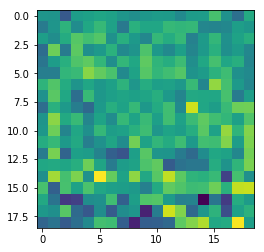

In [47]:
plt.imshow(np.squeeze(model.predict(np.array([game.get_state()]))))

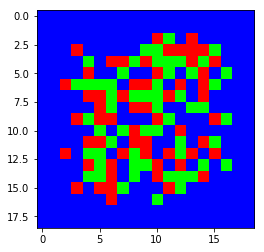

In [48]:
plt.imshow(np.squeeze(training_inputs[300]).astype(float))

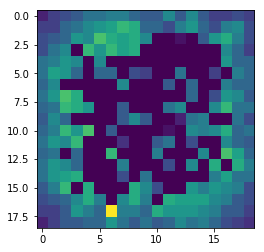

In [49]:
plt.imshow(training_outputs[300])

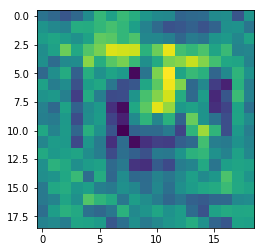

In [50]:
plt.imshow(np.squeeze(model.predict(np.array([training_inputs[300]]))))

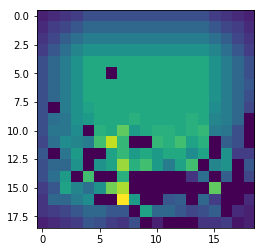

In [51]:
plt.imshow(get_value_map(game.get_state()))

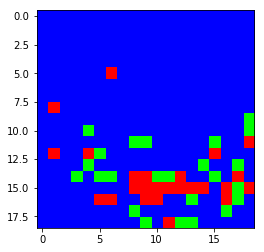

In [52]:
plt.imshow(game.get_state())

In [ ]:
model.fit(
        np.array(training_inputs),  np.expand_dims(np.array(training_outputs), 3), 
        validation_data=(np.array(valid_inputs), np.expand_dims(np.array(valid_outputs), 3)), 
        shuffle=True, epochs=5, verbose=True
)

In [100]:
model.save_weights('/data/trained_models/gomoku_q_learn/initial_v1.h5')